<a href="https://colab.research.google.com/github/ritwiks9635/image_recognition_and_summarization/blob/main/image_recognition_and_summarization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install Pillow easyocr pandas numpy opencv-python -U google-generativeai gradio

In [8]:
import os
import re
import cv2
import json
import easyocr
import warnings
import numpy as np
import pandas as pd
from PIL import Image
import gradio as gr
from google import genai
from google.genai import types
from IPython.display import display, Markdown

warnings.filterwarnings('ignore')

In [ ]:
from google.colab import userdata
GOOGLE_API_KEY = userdata.get("GOOGLE_API_KEY")
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
client = genai.Client(api_key=os.environ.get("GOOGLE_API_KEY"))


reader = easyocr.Reader(['en'], gpu=False)

IMAGE_FILES = [
    "/content/image1 (1).jpeg",
    "/content/image0.jpeg",
    "/content/error 2.png",
    "/content/error sceenshot.png"
]

In [3]:
def extract_raw_text_easyocr(image_path):
    """
    Performs OCR using EasyOCR and returns a single, consolidated string of text.
    """
    try:
        if not os.path.exists(image_path):
            print(f"File not found: {image_path}. Skipping.")
            return ""

        img = cv2.imread(image_path)
        if img is None:
            return ""

        results = reader.readtext(img, detail=0)

        return "\n".join(results).strip()

    except Exception as e:
        print(f"❌ Error during EasyOCR processing of {image_path}: {e}")
        return ""

In [4]:
def clean_extracted_text(text):
    """
    Cleans the raw OCR text to remove common noise, artifacts, and standardize formatting.
    This step is less aggressive than with pytesseract due to EasyOCR's quality.
    """
    if not text:
        return ""

    text = re.sub(r'[\r\t\f]', ' ', text)

    text = re.sub(r'\n{2,}', '\n\n', text)
    text = re.sub(r' {2,}', ' ', text).strip()

    text = text.replace('TO3OK', 'T030K')
    text = text.replace('Engironment', 'Environment')

    return text

In [ ]:
# text = extract_raw_text_easyocr("/content/image1 (1).jpeg")
# clean_text = clean_extracted_text(text)
# print(clean_text)

In [5]:
def process_extracted_text_with_ai(raw_text):
    if not raw_text:
        return {
            "Subject (Brief Description of the issue)": "OCR Failed - No Text Extracted",
            "Details Issue Description": "The OCR process returned no meaningful text."
        }

    summary_schema = types.Schema(
        type=types.Type.OBJECT,
        properties={
            "Subject": types.Schema(
                type=types.Type.STRING,
                description="A concise, technical summary of the SAP error, including the error code if available (e.g., 'SAP FI Error F5562: Posting to Automatic Account')."
            ),
            "Details_Issue_Description": types.Schema(
                type=types.Type.STRING,
                description="A detailed description providing the Diagnosis, System Response, Error Analysis, a clear description of the business requirements/context that led to the error, and the expected successful outcome. Use markdown headers for clarity (e.g., **Diagnosis/Analysis:**, **Requirements/Context:**, **Expected Outcome:**)."
            )
        },
        required=["Subject", "Details_Issue_Description"]
    )

    system_instruction = (
        "You are an expert SAP Technical Support Analyst. Analyze the raw OCR text "
        "from SAP error screenshots and consolidate the information into a single, structured support ticket summary. "
        "Synthesize all technical details into the required fields. "
        "Crucially, **infer the business context or requirement** that caused the error and state the **expected outcome**."
    )

    prompt = (
        f"Analyze the following raw SAP error text and generate a structured summary:\n\n"
        f"RAW TEXT:\n---\n{raw_text}\n---"
    )

    try:
        response = client.models.generate_content(
            model='gemini-2.5-flash',
            contents=prompt,
            config=types.GenerateContentConfig(
                system_instruction=system_instruction,
                response_mime_type="application/json",
                response_schema=summary_schema,
            ),
        )

        summary_json = json.loads(response.text)

        return {
            "Subject (Brief Description of the issue)": summary_json["Subject"],
            "Details Issue Description": summary_json["Details_Issue_Description"]
        }

    except Exception as e:
        print(f"❌ Error during EasyOCR processing of {image_path}: {e}")
        return {
            "Subject (Brief Description of the issue)": "AI Summarization Failed (API Error)",
            "Details Issue Description": f"Could not process text using AI. Check API Key and network connection."
        }


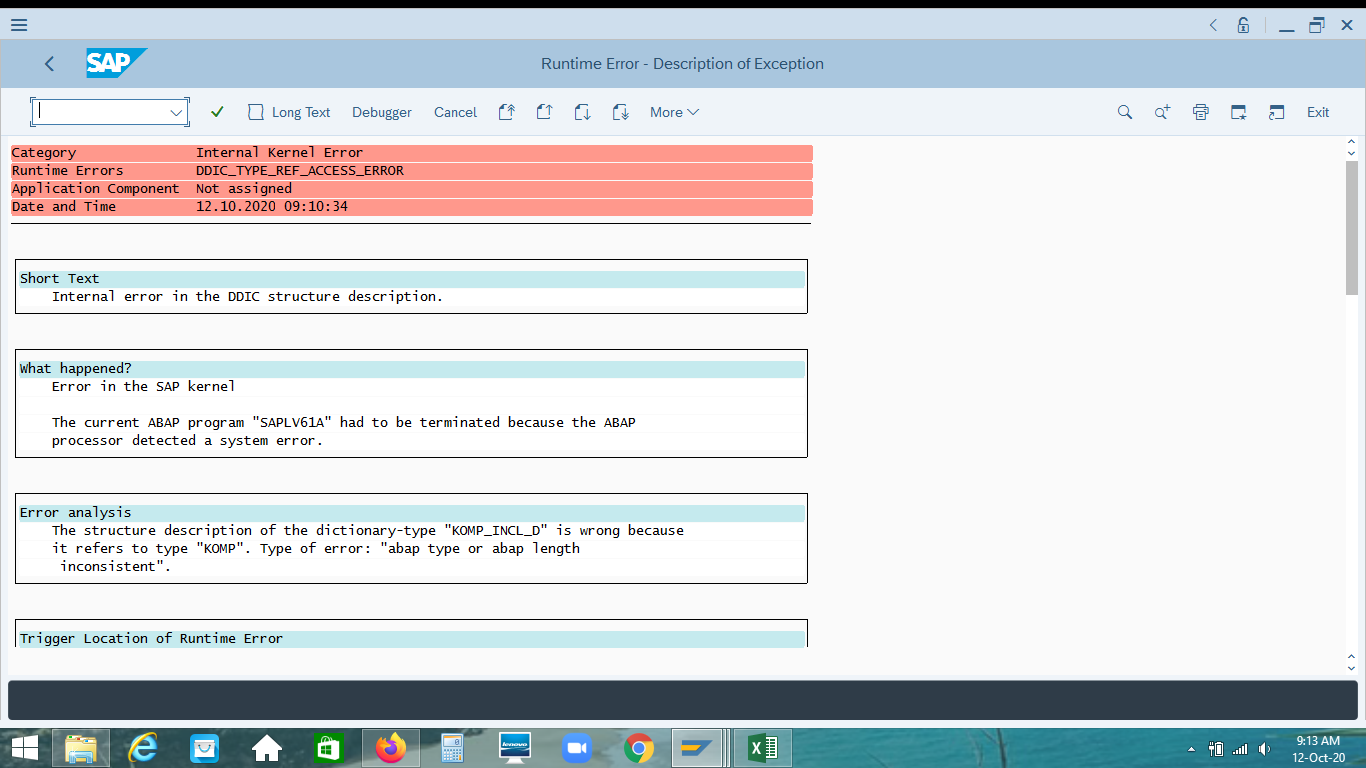


**Subject:** SAP Kernel Error DDIC_TYPE_REF_ACCESS_ERROR in program SAPLV61A

**Details:**
**Diagnosis/Analysis:**A runtime error 'DDIC_TYPE_REF_ACCESS_ERROR' occurred in the SAP kernel, leading to the termination of ABAP program 'SAPLV61A'. The short text indicates an internal error in the DDIC structure description. The detailed analysis states that the structure description of the dictionary-type 'KOMP_INCL' is incorrect because it refers to type 'KOMP', indicating an inconsistency in ABAP type or length definitions. This internal error was detected by the ABAP processor.The error occurred on 12.10.2020 at 09:10:34.**Requirements/Context:**The program 'SAPLV61A' is a standard SAP program typically involved in sales and distribution (SD) processing, particularly related to pricing procedures and calculations. The structures 'KOMP_INCL' and 'KOMP' are core components of pricing communication structures (Pricing Communication Item). This error suggests that a sales-related transaction (e.g., creating a sales order, changing a sales document, or executing a pricing-related function) was attempted, and during its execution, the system encountered an inconsistency in how these critical DDIC structures are defined or referenced. This could stem from recent transports, custom developments impacting KOMP, or system inconsistencies.**Expected Outcome:**The user expects to successfully complete the sales-related transaction or pricing determination without encountering an internal kernel error. The system should correctly process and reference the DDIC structures 'KOMP_INCL' and 'KOMP' without any inconsistencies in their definition or usage.


In [12]:
image_path = "/content/error sceenshot.png"
display(Image.open(image_path))
text = extract_raw_text_easyocr(image_path)
raw_text = clean_extracted_text(text)

summary_dict = process_extracted_text_with_ai(raw_text)

markdown_output = f"""
**Subject:** {summary_dict.get("Subject (Brief Description of the issue)", "N/A")}

**Details:**
{summary_dict.get("Details Issue Description", "N/A")}
"""

display(Markdown(markdown_output))

In [17]:
def mock_ocr_and_process(image):
    """
    Takes an image input from Gradio, runs mock OCR, and calls the AI processing function.
    """
    if image is None:

        return "Brief description of the issue", "Provide detailed description of your issue, requirements, and expected outcome..."

    text = extract_raw_text_easyocr(image)
    raw_text = clean_extracted_text(text)

    summary_dict = process_extracted_text_with_ai(raw_text)

    subject = summary_dict.get("Subject (Brief Description of the issue)", "Error")
    details = summary_dict.get("Details Issue Description", "Error retrieving details.")

    return subject, details

In [18]:
custom_css = """
/* General Gradio element styling for a clean, box-shadow-free look */
.gr-box, .gr-textbox {
    box-shadow: none !important;
    border-color: #e5e7eb !important;
}

/* Style for the Subject and Detailed Description fields */
#subject_field, #details_field {
    border-radius: 6px;
    padding: 0;
}

/* Style the Attachments section to look like the image */
#attachments_box {
    border: 2px dashed #d1d5db !important;
    border-radius: 8px;
    padding: 20px;
    background-color: #f9fafb;
    text-align: center;
}

/* Container for Detailed Description and Buttons (to match image layout) */
#details_container {
    position: relative;
}
#action_buttons {
    position: absolute;
    top: 5px; /* Adjust as needed */
    right: 5px; /* Adjust as needed */
    display: flex;
    gap: 8px;
    z-index: 10;
}
#action_buttons button {
    background-color: #ffffff;
    border: 1px solid #d1d5db;
    color: #374151;
    font-weight: 500;
    padding: 4px 12px;
    border-radius: 4px;
    display: flex;
    align-items: center;
    gap: 4px;
}
#action_buttons button:hover {
    background-color: #f3f4f6;
}
"""

with gr.Blocks(css=custom_css, title="AI SAP Ticket Generator") as demo:
    gr.Markdown("# 🤖 AI SAP Error Ticket Generator")
    gr.Markdown("Upload an SAP error screenshot to automatically generate a structured support ticket summary.")

    with gr.Column(variant="panel"):


        gr.Markdown("## Subject *")
        subject_output = gr.Textbox(
            label="",
            value="Brief description of the issue",
            placeholder="Brief description of the issue",
            interactive=False,
            elem_id="subject_field"
        )


        gr.Markdown("## Detailed Issue Description *")
        with gr.Column(elem_id="details_container"):
            with gr.Row(elem_id="action_buttons"):
                gr.Button("🔍 AI Search", size="sm")
                gr.Button("📝 Grammar", size="sm")

            details_output = gr.Textbox(
                label="",
                value="Provide detailed description of your issue, requirements, and expected outcome...",
                placeholder="Provide detailed description of your issue, requirements, and expected outcome...",
                lines=10,
                interactive=False,
                elem_id="details_field"
            )

    # --- Attachments Section ---
    gr.Markdown("## Attachments")
    with gr.Group(elem_id="attachments_box"):
        image_input = gr.File(
            label="",
            file_count="single",
            file_types=["image"],
            type="filepath",
            interactive=True
        )
        gr.Markdown("Drag and drop files here, or click to browse")

    process_btn = gr.Button("Generate AI Summary", variant="primary")

    process_btn.click(
        fn=mock_ocr_and_process,
        inputs=[image_input],
        outputs=[subject_output, details_output]
    )

    gr.Markdown("---")
    gr.Markdown("Powered by Google Gemini 2.5 Flash (Free Tier) for SAP analysis.")

if __name__ == "__main__":
    demo.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://2e06e542a547e3a6ca.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
